<a href="https://colab.research.google.com/github/PradeepKumarM30/WinterSemester2020-21/blob/DeepLearning/20MAI0030EX4/AlexNetTransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Feature Extraction + Fine Tuning on Large dataset for Alexnet(9305,2326,2326)**

# **Step 1 : Load all necessary inputs**

In [19]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,\
 Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np


# **2. Build the model**

In [20]:
model = Sequential()

layer1 = Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11),strides=(4,4), padding='valid')
model.add(layer1)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
model.add(BatchNormalization())

model.add(Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='valid'))
model.add(BatchNormalization())

model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding='valid'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding='valid'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(4096, input_shape=(224,224,3,)))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

model.add(Dense(1000))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

model.add(Dense(17))
model.add(Activation('softmax'))

model.summary()





Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 54, 54, 96)        34944     
_________________________________________________________________
activation_9 (Activation)    (None, 54, 54, 96)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 23, 23, 256)       614656    
_________________________________________________________________
activation_10 (Activation)   (None, 23, 23, 256)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 11, 11, 256)      

# **3.Load the Large dataset**

In [21]:


tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


# **4. Visualisation of dataset**

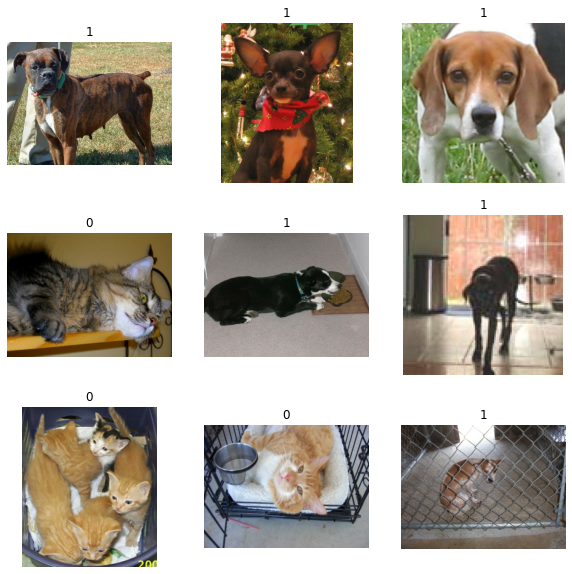

In [22]:

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

# **5. Scaling and resizing of the images**

In [23]:
size = (224, 224)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [24]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

# **6 . Data Augmentation (Optional)**

In [25]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

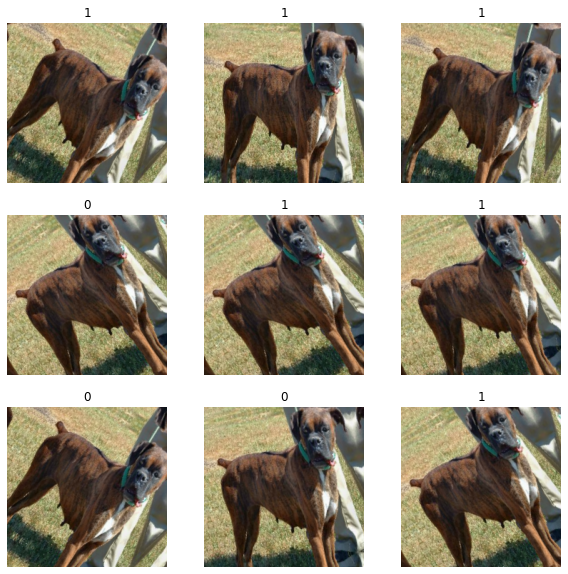

In [26]:

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

# **7 . Model as a feature extractor**

In [27]:
model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)  # Apply random data augmentation


norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = model(x, training=False)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
normalization_2 (Normalizati (None, 224, 224, 3)       7         
_________________________________________________________________
sequential_2 (Sequential)    (None, 17)                34126081  
_________________________________________________________________
dropout_8 (Dropout)          (None, 17)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 18        
Total params: 34,126,106
Trainable params: 18
Non-trainable params: 34,126,088
______________________________________________

In [28]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 5
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20


 46/291 [===>..........................] - ETA: 2:47 - loss: 0.6934 - binary_accuracy: 0.5113

KeyboardInterrupt: ignored

# **8. Fine tuning the model**

In [29]:
model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
normalization_2 (Normalizati (None, 224, 224, 3)       7         
_________________________________________________________________
sequential_2 (Sequential)    (None, 17)                34126081  
_________________________________________________________________
dropout_8 (Dropout)          (None, 17)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 18        
Total params: 34,126,106
Trainable params: 34,104,963
Non-trainable params: 21,143
__________________________________________

KeyboardInterrupt: ignored

# **2. Feature extraction  + Fine tuning for small dataset (2326,465,233)**

In [30]:


tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:10%]", "train[10%:12%]", "train[12%:13%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Number of training samples: 2326
Number of validation samples: 465
Number of test samples: 233


In [31]:
size = (224, 224)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [32]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

In [33]:
model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)  # Apply random data augmentation


norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = model(x, training=False)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
normalization_3 (Normalizati (None, 224, 224, 3)       7         
_________________________________________________________________
model_2 (Functional)         (None, 1)                 34126106  
_________________________________________________________________
dropout_9 (Dropout)          (None, 1)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 2         
Total params: 34,126,115
Trainable params: 2
Non-trainable params: 34,126,113
_______________________________________________

In [34]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
 6/73 [=>............................] - ETA: 53s - loss: 0.6933 - binary_accuracy: 0.4659

KeyboardInterrupt: ignored

In [18]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
 2/73 [..............................] - ETA: 1:18 - loss: 0.6977 - binary_accuracy: 0.4297

KeyboardInterrupt: ignored